# jobflow

## Define workflow with jobflow

In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from python_workflow_definition.jobflow import write_workflow_json

In [4]:
from workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
workflow_json_filename = "jobflow_qe.json"

In [6]:
calculate_qe = job(_calculate_qe)
generate_structures = job(_generate_structures)
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [7]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [8]:
structure = get_bulk_structure(
    element="Al",
    a=4.04,
    cubic=True,
)

In [9]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [10]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [11]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [12]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [13]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [14]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [15]:
!cat {workflow_json_filename}

{"nodes": [{"id": 0, "function": "workflow.get_bulk_structure"}, {"id": 1, "function": "workflow.calculate_qe"}, {"id": 2, "function": "workflow.generate_structures"}, {"id": 3, "function": "workflow.calculate_qe"}, {"id": 4, "function": "workflow.calculate_qe"}, {"id": 5, "function": "workflow.calculate_qe"}, {"id": 6, "function": "workflow.calculate_qe"}, {"id": 7, "function": "workflow.calculate_qe"}, {"id": 8, "function": "workflow.plot_energy_volume_curve"}, {"id": 9, "value": "Al"}, {"id": 10, "value": 4.04}, {"id": 11, "value": true}, {"id": 12, "value": "mini"}, {"id": 13, "function": "python_workflow_definition.shared.get_dict"}, {"id": 14, "value": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}}, {"id": 15, "value": [3, 3, 3]}, {"id": 16, "value": "vc-relax"}, {"id": 17, "value": 0.02}, {"id": 18, "value": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1]}, {"id": 19, "value": "strain_0"}, {"id": 20, "function": "python_workflow_definition.shared.get_dict"}, {"id": 21, "value": "scf"}, {"id"

## Load Workflow with aiida

In [16]:
from aiida import orm, load_profile

load_profile()

Profile<uuid='0ebe77003eb640d5b073762df56b1814' name='pwd'>

In [17]:
from python_workflow_definition.aiida import load_workflow_json

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg.nodes.get_bulk_structure1.inputs.a.value = orm.Float(4.05)

In [20]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

04/24/2025 02:18:49 PM <1741> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [58|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_bulk_structure1
04/24/2025 02:18:49 PM <1741> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [58|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1, type: PyFunction, finished.
04/24/2025 02:18:49 PM <1741> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [58|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict10
04/24/2025 02:18:50 PM <1741> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [58|WorkGraphEngine|update_task_state]: Task: get_dict10, type: PyFunction, finished.
04/24/2025 02:18:50 PM <1741> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [58|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe2
[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01816] mca_base_component_repository_open: unable to ope

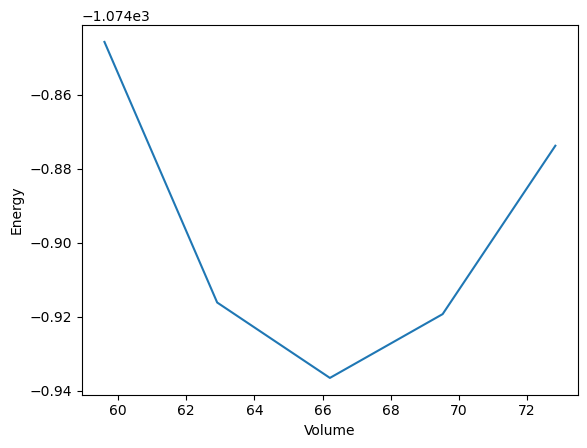

In [21]:
wg.run()

## Load Workflow with pyiron_base

In [22]:
from python_workflow_definition.pyiron_base import load_workflow_json

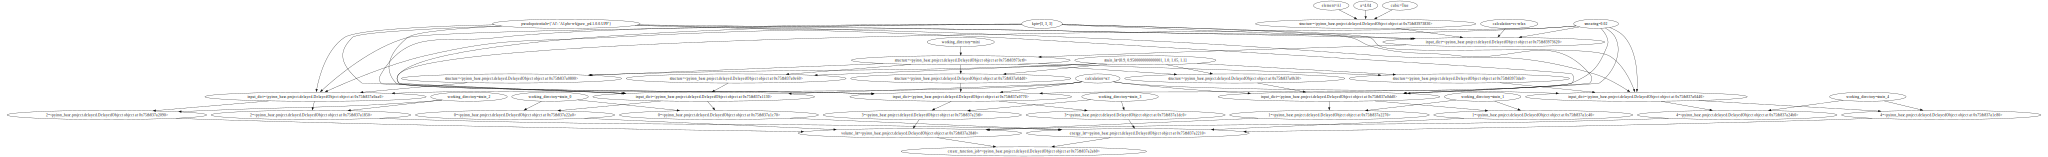

In [23]:
delayed_object_lst = load_workflow_json(file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [24]:
delayed_object_lst[0].input['a'] = 4.05

The job get_bulk_structure_2ca4aeae204ceaa28593c93054b07908 was saved and received the ID: 1
The job get_dict_1e47509b88d63a21fd421686554c8f4a was saved and received the ID: 2
The job calculate_qe_411e578f2700d09ba2df9a4c682b4582 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01906] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_a2be118b5bff59eaa11d83f99eaced4d was saved and received the ID: 4
The job get_dict_e6e21d04c5680e1114b80a92bc2e359c was saved and received the ID: 5
The job calculate_qe_51a232f4324d311c7fd4f7f769ddfdfe was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01916] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_437c0ffaf598d0a286c53012d3d36f25 was saved and received the ID: 7
The job calculate_qe_8fb25b130b8e8e933d28d21f7c44b4ca was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01926] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_d1a00c031f330c896c8f5af25db5235b was saved and received the ID: 9
The job calculate_qe_042e4d560dcfc093eea3a34f7e523669 was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01938] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_ea36d0f502795b1fc4b32e62fce9820d was saved and received the ID: 11
The job calculate_qe_b4bd2031ca3d40580969fda1aecee94a was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01948] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_d190d6b6e585cababdcd49a344547984 was saved and received the ID: 13
The job calculate_qe_b3927880779bfca53ff78c00360e9527 was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-kk01elen:01958] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_90f0281f335962d10db1b3572abe82df was saved and received the ID: 15
The job get_list_09fa36007fd192f793a1f218b70fe87b was saved and received the ID: 16
The job plot_energy_volume_curve_8d8f280c69be12b1969d95cc53f9411b was saved and received the ID: 17


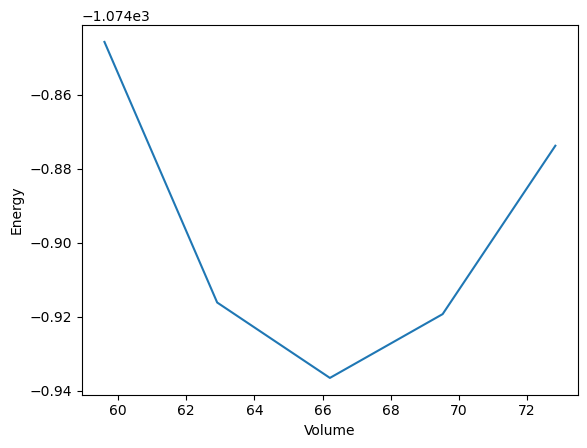

In [25]:
delayed_object_lst[-1].pull()